In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook()

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2019-02-20 
Git hash: 2db29778708209bb252d7237edb7fb6db71d3f3a


In [3]:
# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')

In [4]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sramongo']
ncbi = db['ncbi']

In [5]:
ncbi.count()

44081

In [6]:
ncbi.find({'sra.experiment.library_strategy': 'RNA-Seq'}).count()

15558

In [7]:
ncbi.find({'biosample.contacts.first_name': 'Brian', 'biosample.contacts.last_name': 'Oliver'}).count()

4812

In [8]:
ncbi.find({'biosample.contacts.first_name': 'Brian', 'biosample.contacts.last_name': 'Oliver', 'sra.experiment.library_strategy': 'RNA-Seq'}).count()

4797

In [9]:
ncbi.find({'sra.experiment.library_strategy': 'ChIP-Seq'}).count()

4402

In [10]:
ncbi.find({'biosample.contacts.first_name': 'Brian', 'biosample.contacts.last_name': 'Oliver', 'sra.experiment.library_strategy': 'ChIP-Seq'}).count()

15

In [11]:
sns.set_context('talk')

In [12]:
records = ncbi.aggregate([
    {
        '$match': {
            'sra.experiment.library_strategy': 'RNA-Seq'
        }
    },
    {'$unwind': {'path': '$runs'}},
    {
        '$project': {
                '_id': False,
                'srx': '$srx',
                'srr': '$runs.srr',
                'date': '$runs.load_date',
                'contacts': {'$arrayElemAt': [{'$arrayElemAt': ['$biosample.contacts', 0]}, 0]},
                'first_name': '$sra.organization.first_name',
                'last_name': '$sra.organization.last_name'
            }
        },
])

flat_records = []
for record in records:
    contacts = record.get('contacts', None)
    
    if contacts is None:
        contacts = {
            'first_name': record.get('first_name', ''),
            'last_name': record.get('last_name', '')
        }
    
        
    flat_records.append(
        (
            record['srx'],
            record['srr'],
            record.get('date', ''),
            contacts.get('first_name', ''),
            contacts.get('last_name', ''),
            contacts.get('email', ''),
        )
    )

contacts = (
    pd.DataFrame(flat_records, columns=['srx', 'srr', 'date', 'first_name', 'last_name', 'email'])
    .set_index('srx', 'srr')
    .assign(name = lambda df: df.first_name.str.cat(df.last_name, sep=' '))
    .drop(['first_name', 'last_name'], axis=1)
)

In [13]:
cnts = contacts.groupby('name').size().sort_values(ascending=False).rename('counts').iloc[:20].to_frame().reset_index().query('name != " "')
bcnts = cnts.iloc[0, 1]

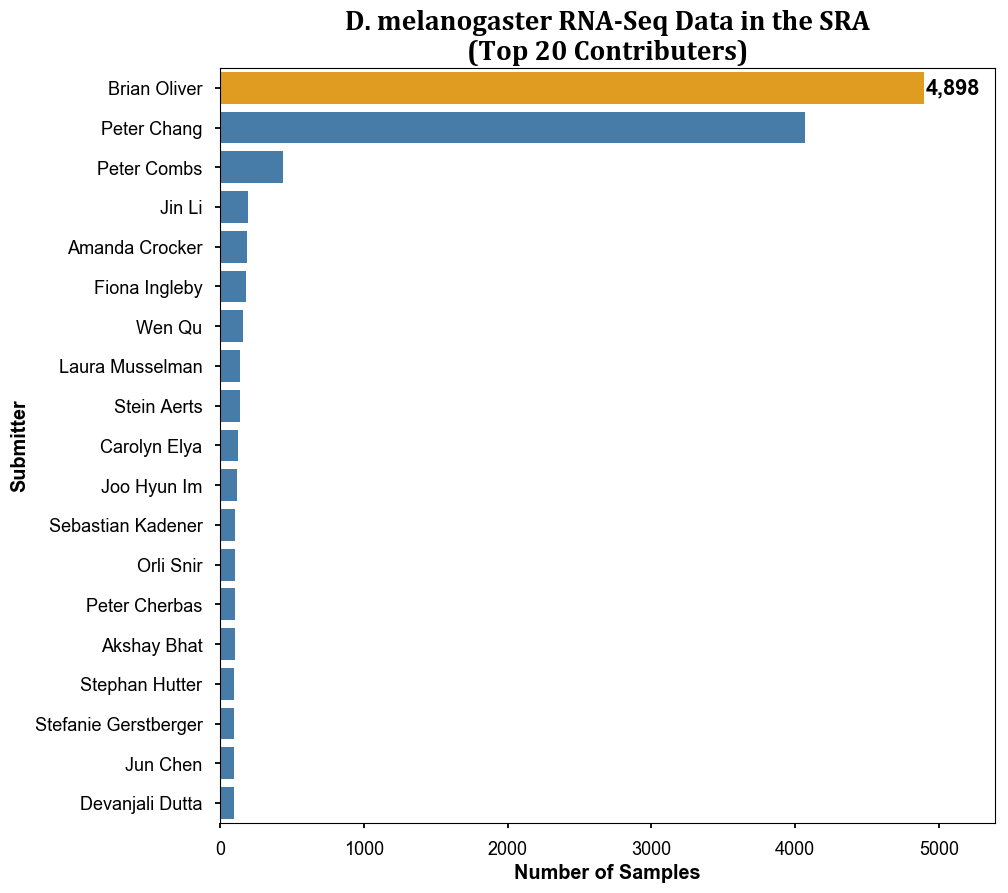

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

colors = ['C0'] * 20
colors[0] = 'orange'

sns.barplot('counts', 'name', data=cnts, palette=colors, ax=ax)

ax.set_ylabel('Submitter', fontweight='bold')
ax.set_xlabel('Number of Samples', fontweight='bold')
ax.set_title('D. melanogaster RNA-Seq Data in the SRA\n(Top 20 Contributers)', fontsize=20, family='Cambria')
ax.text(bcnts+10, 0, f'{bcnts:,}', ha='left', va='center', fontweight='bold')
ax.margins(.1)
plt.savefig('../output/notebook/2019-02-20_sra_number_for_brian.svg', bbox_inches='tight')